# Data Import

In [49]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline, Pipeline
from category_encoders import OrdinalEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

import pickle


# from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
# import shap


In [ ]:
# data_path = ("C:\\Users\\EAFle\\U3S4_BW\\GitHub_Repo\\Kickstarter\\data-modeling-1\\KickstarterCleanedv3.csv")

# raw_df = pd.read_csv(data_path, index_col='idb

In [3]:
raw_df = pd.read_csv('KickstarterCleaned.zip', index_col='id')

# Exploratory Data Analysis

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218361 entries, 1629235715 to 807310529
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         218361 non-null  int64  
 1   backers_count      218361 non-null  int64  
 2   blurb              218353 non-null  object 
 3   category           218361 non-null  object 
 4   country            218361 non-null  object 
 5   created_at         218361 non-null  object 
 6   deadline           218361 non-null  object 
 7   goal               218361 non-null  float64
 8   launched_at        218361 non-null  object 
 9   name               218361 non-null  object 
 10  pledged            218361 non-null  float64
 11  spotlight          218361 non-null  int64  
 12  staff_pick         218361 non-null  int64  
 13  state              218361 non-null  int64  
 14  state_changed_at   218361 non-null  object 
 15  usd_exchange_rate  218361 non-null  flo

In [5]:
# from pandas_profiling import ProfileReport

In [6]:
# profile = ProfileReport(raw_df, minimal=True)
# profile.to_file(output_file="profile.html")

# Dataframe Cleaning

In [5]:
# Applying the necessary data cleaning and featuring engineering
# in one wrangle function.

def wrangle(df):

    # Defining new reader friendly column names
    column_names = ['Kickstarter_id', 'Backers Count', 'Campaign Description', 'Primary Category', \
        'Country', 'Campaign Created', 'Deadline', 'Campaign Goal', 'Campaign Start', \
        'Product Name', 'Amount Pledged', 'Product Spotlight', 'Staff Pick', 'Status', \
        'Goal Reached Date', 'USD Exchange Rate', 'USD Pledged', 'Description Length', 'Goal in USD', \
        'Campaign Length', 'Subcategory']
    df.columns = column_names


    # Capitalizing the category and subcategory data points for an easier read
    df['Primary Category'] = df['Primary Category'].str.title()
    df['Subcategory'] = df['Subcategory'].str.title()


    # Converting date columns to datetime dtype
    date_columns = ['Campaign Created', 'Deadline', 'Campaign Start', 'Goal Reached Date']
    df[date_columns] = df[date_columns].apply(pd.to_datetime)


    # Dropping columns and rows not applicable to an American audience
    non_essential_columns = ['Kickstarter_id', 'USD Exchange Rate', 'USD Pledged', 'Goal in USD', 'Product Spotlight']
    df.drop(columns=non_essential_columns, axis=1, inplace=True)
    df.drop(df.loc[df['Country']!='US'].index, inplace=True)


    # Correcting country name with ISO country code name
    df['Country'] = df['Country'].replace('US', 'USA')
    df.drop(columns='Country', inplace=True)
    
    # Remove weird dict strings in Primary Category
    df['Primary Category'] = df['Primary Category'].apply(lambda x: re.findall(r"[a-zA-z]+", x)[0])

    # Filling absent subcategory values with primary category values
    # We don't want to discredit a product because it cannot qualify
    # For a granular subcategory
    df[['Primary Category', 'Subcategory']] = df[['Primary Category', 'Subcategory']].astype(str)
    df['Subcategory'].fillna(df['Primary Category'], inplace=True)


    # Dropping rows with no campaign description
    # As they may not be serious campaigns
    # This data may also provide future data leakage indicating campaign failure.
    df.dropna(axis=0, inplace=True)


    # Creating features to indicate goal and pledge amounts per day and per backer
    # These features can assist campaign success measurements
    # df['Goal Amount Per Backer'] = round(df['Campaign Goal']/df['Backers Count'])
    # df['Pledge Amount Per Backer'] = round(df['Amount Pledged']/df['Backers Count'])
    df['Goal Amount Per Day'] = round(df['Campaign Goal']/df['Campaign Length'])
    # df['Pledge Amount Per Day'] = round(df['Amount Pledged']/df['Campaign Length'])
      
    # Engineered feature: Did campaign start in Nov, Dec, or Feb.
    df['Holiday Season'] = df['Campaign Start'].dt.month.isin([11,12,1]).astype(int)

    # Creating data to quantify the time from campagin creation to start
    df['Campaign Launch Length'] = df['Campaign Start'].sub(df['Campaign Created'], axis=0).astype('timedelta64[D]')#.astype(int)#####
    
    # Remove duplicate 'Product Name' rows
    df.drop_duplicates(subset=['Product Name'], keep='first', inplace=True)
    df.drop_duplicates(subset=['Campaign Description'], keep='first', inplace=True)

    
    ## Group lower categories into 1 bucket as 'Other' (to balance out the categories and reduce cardinality) - reversed as this significantly lowered the score
    # prim_cat_counts = pd.DataFrame(df['Primary Category'].value_counts(normalize=True))
    # group_cats = prim_cat_counts[prim_cat_counts['Primary Category'] < 0.04].index
    # def repl_cat(cat): # Define a function to replace a value with 'Other' if it is in group_cats list
    #   if cat in group_cats:
    #     return 'Other'
    #   else:
    #     return cat
    # df['Primary Category'] = df['Primary Category'].apply(repl_cat)

    # Drop leaky features
    df.drop(columns=['Backers Count', 'Amount Pledged'], inplace=True)

    # Drop redundant or duplicate features
    df.drop(columns=['Campaign Created', 'Deadline', 'Goal Reached Date', 'Goal Amount Per Day'], inplace=True)

    # Engineer feature for product name length and drop the original product name feature
    df['Product Name Length'] = df['Product Name'].str.len()
    df.drop(columns='Product Name', inplace=True)

    return df

In [7]:
df = wrangle(raw_df.copy())
df.head()

,Campaign Description,Primary Category,Campaign Goal,Campaign Start,Staff Pick,Status,Description Length,Campaign Length,Subcategory,Holiday Season,Campaign Launch Length,Product Name Length
id,,,,,,,,,,,,
1629235715,A Steve Lafler graphic novel,Comics,599.0,2020-09-01,0,1,5.0,23,Graphic Novels,0,5.0,40
1593905291,What happens when two drug-fueled lowlifes fin...,Comics,2000.0,2017-02-14,0,1,20.0,30,Graphic Novels,0,29.0,14
1341470613,A pillow meant for two.,Crafts,500.0,2015-02-03,0,0,5.0,30,Diy,0,2.0,20
510157690,Professional conservation of the 1880's mural ...,Art,17000.0,2019-03-10,0,0,18.0,45,Painting,0,137.0,42
147824964,"We are trying to raise $2,500 for an art proje...",Art,2500.0,2013-02-04,0,1,14.0,60,Performance Art,0,221.0,27


In [21]:
# df[df['Goal Amount Per Backer'] > 10000000].head()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131714 entries, 1629235715 to 2093445204
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Campaign Description    131714 non-null  object        
 1   Primary Category        131714 non-null  object        
 2   Campaign Goal           131714 non-null  float64       
 3   Campaign Start          131714 non-null  datetime64[ns]
 4   Staff Pick              131714 non-null  int64         
 5   Status                  131714 non-null  int64         
 6   Description Length      131714 non-null  float64       
 7   Campaign Length         131714 non-null  int64         
 8   Subcategory             131714 non-null  object        
 9   Holiday Season          131714 non-null  int32         
 10  Campaign Launch Length  131714 non-null  float64       
 11  Product Name Length     131714 non-null  int64         
dtypes: datetime64[ns]

In [121]:
# There are some 'nan' values (as a string)
df['Subcategory'].value_counts(normalize=True)

nan                0.038781
Web                0.017022
Indie Rock         0.015944
Narrative Film     0.015799
Comedy             0.015435
                     ...   
Social Practice    0.000418
Letterpress        0.000395
Residencies        0.000380
Chiptune           0.000258
Taxidermy          0.000046
Name: Subcategory, Length: 147, dtype: float64

In [32]:
# my_cols = ['Goal Reached Date', 'Description Length', 'Campaign Length', 
#            'Pledge Amount Per Backer', 'Goal Amount Per Day', 
#            'Pledge Amount Per Day', 'Pledge Amount Per Day', 'Campaign Launch Length']

In [26]:
# for col in my_cols:
#     print(df[col].describe())
#     print('\n', '--------------------------------------', '\n')

count                  131714
unique                   4198
top       2014-08-08 00:00:00
freq                      187
first     2009-05-16 00:00:00
last      2021-05-13 00:00:00
Name: Goal Reached Date, dtype: object

 -------------------------------------- 

count    131714.000000
mean         18.315312
std           5.472773
min           1.000000
25%          15.000000
50%          19.000000
75%          22.000000
max          43.000000
Name: Description Length, dtype: float64

 -------------------------------------- 

count    131714.000000
mean         33.072475
std          12.203573
min           1.000000
25%          30.000000
50%          30.000000
75%          35.000000
max         120.000000
Name: Campaign Length, dtype: float64

 -------------------------------------- 

count    121160.000000
mean         79.942217
std         140.287901
min           1.000000
25%          28.000000
50%          53.000000
75%          92.000000
max       10000.000000
Name: Pledge Amount P

<ipython-input-26-21302eb0af7e>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df[col].describe())


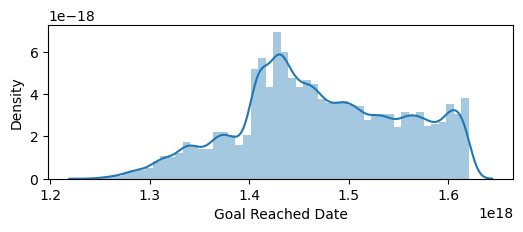

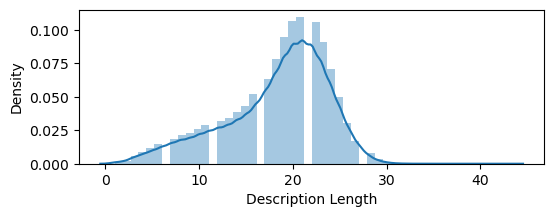

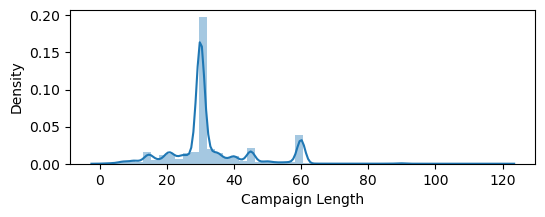

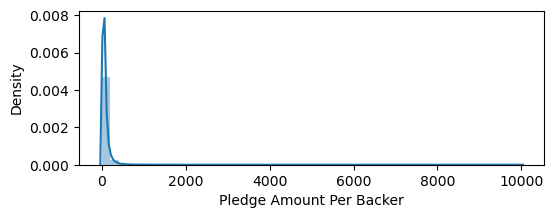

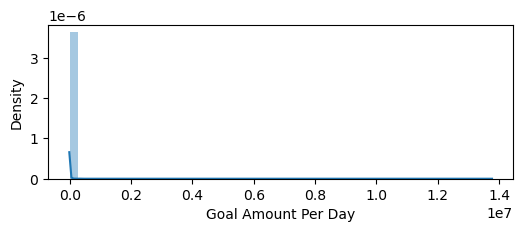

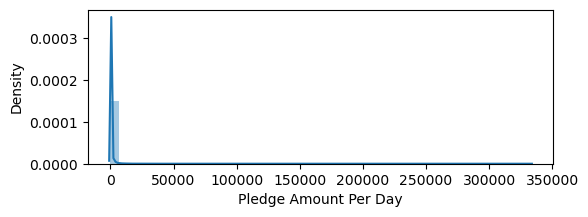

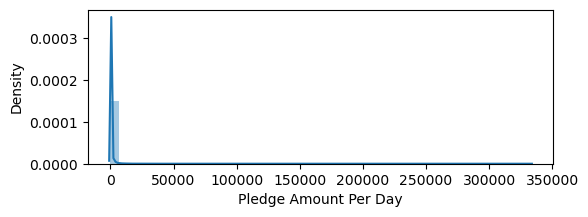

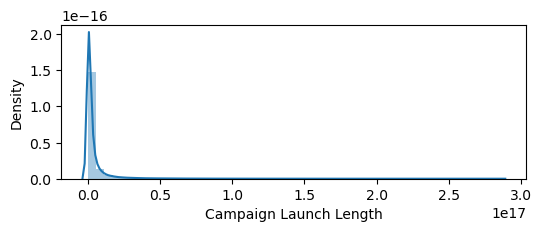

In [46]:
plt.rcParams['figure.figsize'] = [6, 2]
for column in my_cols:
    plt.figure()
    sns.distplot(df[column])
    
plt.show()
plt.rcParams.update(plt.rcParamsDefault)

## Feature Engineering


# Data Visualization


In [87]:
# Bar chart of primary category, subcategories, campaign length https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html

# Whisker plot of campaign goal, amount pledged, backers count https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html

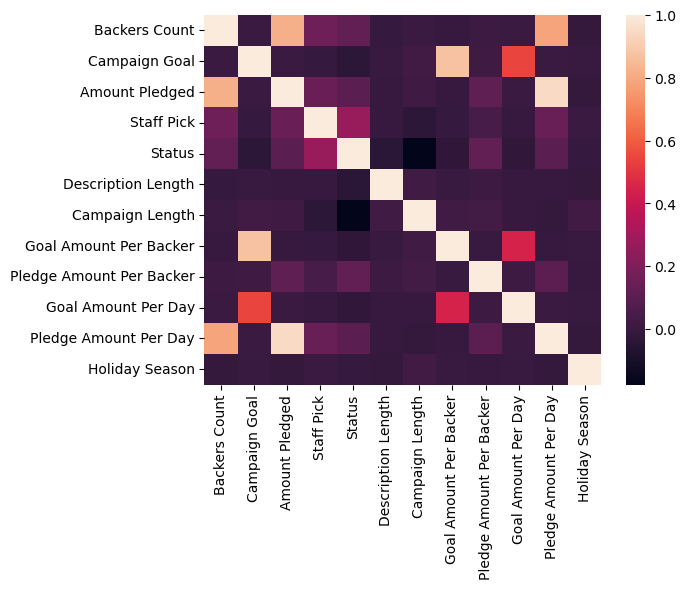

In [48]:
Var_Corr = df.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns)
plt.show()

In [49]:
print(Var_Corr)

                          Backers Count  Campaign Goal  Amount Pledged  \
Backers Count                  1.000000       0.006529        0.819763   
Campaign Goal                  0.006529       1.000000        0.006979   
Amount Pledged                 0.819763       0.006979        1.000000   
Staff Pick                     0.158174      -0.007484        0.143334   
Status                         0.119943      -0.034318        0.100845   
Description Length            -0.007674      -0.000676       -0.003290   
Campaign Length                0.004866       0.030296        0.019644   
Goal Amount Per Backer        -0.003253       0.873165       -0.002715   
Pledge Amount Per Backer       0.016343       0.017390        0.117254   
Goal Amount Per Day            0.003895       0.544682        0.004098   
Pledge Amount Per Day          0.785996       0.006749        0.948110   
Holiday Season                -0.010969       0.001536       -0.011244   

                          Staff Pick 

# Building Models


## * Random Forest

In [112]:
# Establishing feature matrix and y vector.

target = 'Status'

X = df.drop(columns=target)
y = df[target]

X = X[['Primary Category', 'Subcategory', 
       'Backers Count', 'Campaign Goal', 'Amount Pledged',
       'Staff Pick', 'Description Length', 'Campaign Length',
       'Holiday Season', 'Campaign Launch Length']]

print(X.shape)
print(y.shape)
print("The matrix and vector are the same length:", (len(y) == len(X)))

(131714, 10)
(131714,)
The matrix and vector are the same length: True


In [113]:
# fairly balanced
df[target].value_counts(normalize=True)

1    0.573758
0    0.426242
Name: Status, dtype: float64

In [114]:
df.columns

Index(['Backers Count', 'Campaign Description', 'Primary Category',
       'Campaign Created', 'Deadline', 'Campaign Goal', 'Campaign Start',
       'Product Name', 'Amount Pledged', 'Staff Pick', 'Status',
       'Goal Reached Date', 'Description Length', 'Campaign Length',
       'Subcategory', 'Goal Amount Per Backer', 'Pledge Amount Per Backer',
       'Goal Amount Per Day', 'Pledge Amount Per Day', 'Holiday Season',
       'Campaign Launch Length'],
      dtype='object')

In [115]:
first = df['Deadline'].min()
last = df['Deadline'].max()
delta = last - first
cutoff = first + (delta * 0.8)

In [117]:
cutoff_mask = df['Deadline'] > cutoff

X_train = X[~cutoff_mask]
X_test = X[cutoff_mask]

y_train = y[~cutoff_mask]
y_test = y[cutoff_mask]

### Baseline Accuracy

In [122]:
base_score = df[target].value_counts(normalize=True).max()
base_score

0.573758294486539

## * Random Forest Classifier

In [119]:
X.select_dtypes(include='object').columns

Index(['Primary Category', 'Subcategory'], dtype='object')

In [120]:
X.select_dtypes(include='number').columns

Index(['Backers Count', 'Campaign Goal', 'Amount Pledged', 'Staff Pick',
       'Description Length', 'Campaign Length', 'Holiday Season',
       'Campaign Launch Length'],
      dtype='object')

In [126]:
# catagorical features
cat_features = ['Primary Category', 'Subcategory'] 
cat_transformer = OrdinalEncoder()

#numerical features
num_features = ['Backers Count', 'Campaign Goal', 'Amount Pledged',
                'Staff Pick', 'Description Length', 'Campaign Length',
                'Holiday Season', 'Campaign Launch Length']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', 'passthrough', num_features) #no scaler for decision tree models
        ])

pipe = Pipeline(steps = [['preprocessor', preprocessor],
                         ['classifier', RandomForestClassifier(random_state=42)]])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['Primary Category',
                                                   'Subcategory']),
                                                 ('num', 'passthrough',
                                                  ['Backers Count',
                                                   'Campaign Goal',
                                                   'Amount Pledged',
                                                   'Staff Pick',
                                                   'Description Length',
                                                   'Campaign Length',
                                                   'Holiday Season',
                                                   'Campaign Launch '
                                                   'Length'])])),
                ['classifier', RandomForestClassifier(random_st

In [127]:
model_rf = pipe
print('Train accuracy: ', accuracy_score(y_train, model_rf.predict(X_train)))
print('Test accuracy: ', accuracy_score(y_test, model_rf.predict(X_test)))
print('TEST REPORT: \n', classification_report(y_test, model_rf.predict(X_test)))

Train accuracy:  1.0
Test accuracy:  0.9947403253335191
TEST REPORT: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      9219
           1       0.99      1.00      1.00     19490

    accuracy                           0.99     28709
   macro avg       1.00      0.99      0.99     28709
weighted avg       0.99      0.99      0.99     28709



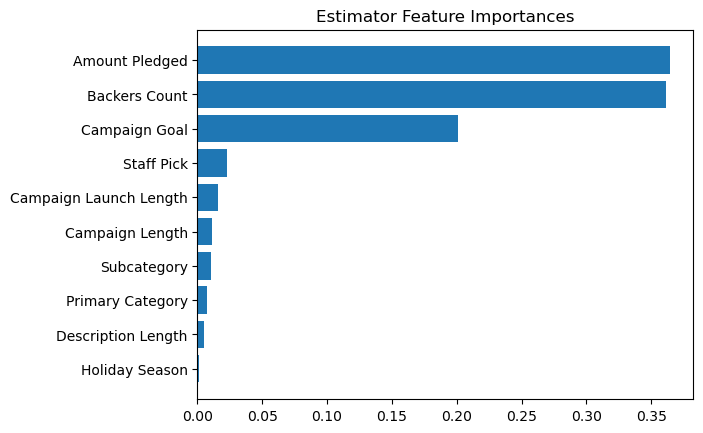

In [128]:
importances =  model_rf.named_steps.classifier.feature_importances_
feature_names = X_train.columns

feat_imp = pd.Series(data=importances,index=feature_names).sort_values()
plt.barh(feat_imp.index, feat_imp.values)
plt.title('Estimator Feature Importances')
plt.show()

In [129]:
# pickle.dump(model_rf, open('test_forest.pkl', 'wb'))

## * Gradient Boosting Model

In [10]:
target = 'Status'
nlp = 'Campaign Description' # Removing Emily's NLP column
date_col = 'Campaign Start' # Do not need date column
X2, y2 = df.drop(columns=[target, nlp, date_col]), df[target]

In [11]:
# Split data into training and validation sets
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size = 0.20, random_state=42)

In [12]:
# Estblish baseline
y2_train.value_counts(normalize=True).max()

0.5733171365935599

In [29]:
# Build model (with staff-pick)
model_gbm = make_pipeline(
    OrdinalEncoder(),
    KNNImputer(),
    StandardScaler(),
    # SimpleImputer(strategy='mean'), 
    GradientBoostingClassifier(random_state=42)
)

model_gbm.fit(X2_train, y2_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Primary Category', 'Subcategory'],
                                mapping=[{'col': 'Primary Category',
                                          'data_type': dtype('O'),
                                          'mapping': Technology      1
Publishing      2
Design          3
Food            4
Photography     5
Film            6
Comics          7
Art             8
Music           9
Journalism     10
Theater        11
Dance          12
Games          13
Crafts         14
Fashion        15
NaN            -2
dtype: int64},
                                         {'col': 'Subcategory',
                                          'data_type': dtype('O'),
                                          'mapping': Gadgets               1
Apps                  2
Children'S Books      3
Wearables             4
Graphic Design        5
                   ... 
Latin               144
Residencies         145
Typography          146

In [30]:
# Check Accuracy
print('GBM Training Accuracy', model_gbm.score(X2_train, y2_train))
print('GBM Validation Accuracy', model_gbm.score(X2_val, y2_val))

# Output:
# GBM Training Accuracy 0.7561378367862125 (with subcat bucketing)
# GBM Validation Accuracy 0.7562160725809512
# GBM Training Accuracy 0.7847984739634245 (w/o subcat bucketing)
# GBM Validation Accuracy 0.7828265573397107
# GBM Training Accuracy 0.7875316738001917 (w/o prim_cat bucketing, with 'Staff Pick')
# GBM Validation Accuracy 0.7853699274949703
# GBM Training Accuracy 0.7596777101859146 (w/o 'Staff Pick')
# GBM Validation Accuracy 0.7568993660554986

GBM Training Accuracy 0.7850357308936994
GBM Validation Accuracy 0.7833580078199142


## * XGB Booster Model

In [32]:
# XGB model (with staff pick)
model_xgb = make_pipeline(
    OrdinalEncoder(),
    # KNNImputer(),
    StandardScaler(),
    XGBClassifier(random_state=42, n_jobs=-1)
)

model_xgb.fit(X2_train, y2_train)

[19:06:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Primary Category', 'Subcategory'],
                                mapping=[{'col': 'Primary Category',
                                          'data_type': dtype('O'),
                                          'mapping': Technology      1
Publishing      2
Design          3
Food            4
Photography     5
Film            6
Comics          7
Art             8
Music           9
Journalism     10
Theater        11
Dance          12
Games          13
Crafts         14
Fashion        15
NaN            -2
dtype: int64},
                                         {'col': 'Subcategory',
                                          'data_type': dtype('O'),
                                          'mapping': Gad...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                       

In [33]:
# Check Accuracy
print('XGB Training Accuracy', model_xgb.score(X2_train, y2_train))
print('XGB Validation Accuracy', model_xgb.score(X2_val, y2_val))

# Output:
# XGB Training Accuracy 0.782672651868161 (with subcat bucketing)
# XGB Validation Accuracy 0.7583039137531792
# XGB Training Accuracy 0.8380199485626976 (w/o subcat bucketing)
# XGB Validation Accuracy 0.8169912310670766
# XGB Training Accuracy 0.8389879568382193 (w/o prim_cat bucketing, with 'Staff Pick')
# XGB Validation Accuracy 0.8185096610105151
# XGB Training Accuracy 0.8176727942223192 (w/o 'Staff Pick')
# XGB Validation Accuracy 0.7933037239494363

XGB Training Accuracy 0.8426037524556093
XGB Validation Accuracy 0.8191170329878905


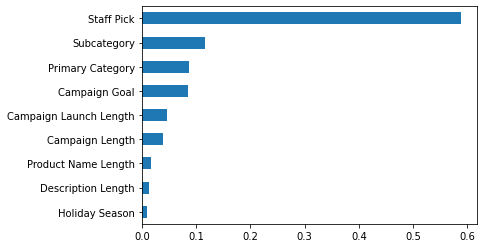

In [34]:
# Feature selection
importances =  model_xgb.named_steps['xgbclassifier'].feature_importances_
feature_names = X2_train.columns
feat_imp =pd.Series(data=importances,index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh');

In [20]:
# Hyperparameter tuning with GridSearchCV:

clf_xgb = make_pipeline(
    OrdinalEncoder(),
    # KNNImputer(),
    StandardScaler(),
    XGBClassifier(random_state=42,n_jobs=-1)
)

param_grid = {
    'xgbclassifier__max_depth': [6],
    'xgbclassifier__learning_rate': [0.3]

}

model_gs = GridSearchCV(
    clf_xgb,
    param_grid = param_grid,
    n_jobs = -1,
    cv = 5,
    verbose = 1
)
model_gs.fit(X2_train, y2_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[18:58:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('standardscaler', StandardScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_ste...
             

In [21]:
model_gs.best_params_

# {'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 6}
# {'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 5}
# {'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 6}
# 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 8}
# {'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 5}
# {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 8}

{'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 6}

In [22]:
print('The best accuracy score for the grid search is: ', model_gs.best_score_)
print('Grid Search Training Accuracy', model_gs.score(X2_train, y2_train))
print('Grid Search Validation Accuracy', model_gs.score(X2_val, y2_val))

# The best accuracy score for the grid search is:  0.8163065677084049
# Grid Search Training Accuracy 0.8272105228193716
# Grid Search Validation Accuracy 0.8281516911513495

# The best accuracy score for the grid search is:  0.8168455985215258
# Grid Search Training Accuracy 0.8375359444249366
# Grid Search Validation Accuracy 0.8407546596818889 (w/prod name length feature - best params 0.3 & 6)

# The best accuracy score for the grid search is:  0.8164959744744019
# Grid Search Training Accuracy 0.8444069051256987
# Grid Search Validation Accuracy 0.8187374255020309 (trained on X2_train, params 0.3 & 6)

# The best accuracy score for the grid search is:  0.8165244689925609
# Grid Search Training Accuracy 0.8426037524556093
# Grid Search Validation Accuracy 0.8191170329878905 (w/o 'Goal Amount Per Day')

The best accuracy score for the grid search is:  0.8165244689925609
Grid Search Training Accuracy 0.8426037524556093
Grid Search Validation Accuracy 0.8191170329878905


In [25]:
# pickle.dump(model_gs.best_estimator_, open('xgb.pkl', 'wb'))

In [45]:
xgb_loaded = pickle.load(open('xgb.pkl','rb'))

In [46]:
xgb_loaded.score(X2_val, y2_val)

0.8191170329878905

## * Multi Output Model to predict two variables - 'Staff Pick' and 'Status'
Since 'Staff Pick' data is not available to users beforehand, we will predict it along with 'Status' by using a multi-output model

In [37]:
# Create two y target vectors and stack them together
target0 = 'Staff Pick'
X_mult, y1_mult, y2_mult = df.drop(columns=[target, nlp, date_col, target0]), df[target0], df[target]
y_mult = np.vstack((y1_mult, y2_mult)).T

In [38]:
# Split data into training and validation sets
X_mult_train, X_mult_val, y_mult_train, y_mult_val = train_test_split(X_mult, y_mult, test_size = 0.20, random_state=42)

In [39]:
# Build Multi Output Classifier model
model_xgb_mult = make_pipeline(
    OrdinalEncoder(),
    # KNNImputer(),
    StandardScaler(),
    MultiOutputClassifier(XGBClassifier(random_state=42, n_jobs=-1), n_jobs=-1)
)

model_xgb_mult.fit(X_mult_train, y_mult_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Primary Category', 'Subcategory'],
                                mapping=[{'col': 'Primary Category',
                                          'data_type': dtype('O'),
                                          'mapping': Technology      1
Publishing      2
Design          3
Food            4
Photography     5
Film            6
Comics          7
Art             8
Music           9
Journalism     10
Theater        11
Dance          12
Games          13
Crafts         14
Fashion        15
NaN            -2
dtype: int64},
                                         {'col': 'Subcategory',
                                          'data_type': dtype('O'),
                                          'mapping': Gad...
                                                               importance_type='gain',
                                                               interaction_constraints=None,
                            

In [40]:
# Check Accuracy
print('XGB (Multi Output) Training Accuracy', model_xgb_mult.score(X_mult_train, y_mult_train))
print('XGB (Multi Output) Validation Accuracy', model_xgb_mult.score(X_mult_val, y_mult_val))

XGB (Multi Output) Training Accuracy 0.7265281718879009
XGB (Multi Output) Validation Accuracy 0.6957446000835137


In [41]:
model_xgb_mult.predict(X_mult_val)[:5]

array([[0, 1],
       [0, 1],
       [0, 0],
       [0, 1],
       [0, 1]], dtype=int64)

In [42]:
# Feature selection (NOT SURE HOW TO GET FEATURE IMPORTANCES FROM MULTI-OUTPUT MODEL)
importances =  model_xgb_mult.named_steps['multioutputclassifier'].feature_importances_
feature_names = X_mult_train.columns
feat_imp =pd.Series(data=importances,index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh');

AttributeError: 'MultiOutputClassifier' object has no attribute 'feature_importances_'

In [43]:
model_xgb_mult.named_steps['multioutputclassifier'].estimator

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

# Evaluating Results

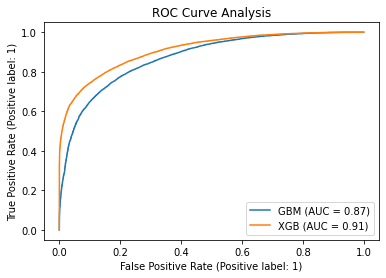

In [60]:
# ROC Curve Analysis
gbm = plot_roc_curve(model_gbm, X2_val, y2_val, name='GBM')
xgb = plot_roc_curve(xgb_loaded, X2_val, y2_val, ax =gbm.ax_, name='XGB')
plt.title('ROC Curve Analysis');

GBM Model
              precision    recall  f1-score   support

           0       0.77      0.69      0.73     11182
           1       0.79      0.85      0.82     15161

    accuracy                           0.78     26343
   macro avg       0.78      0.77      0.77     26343
weighted avg       0.78      0.78      0.78     26343



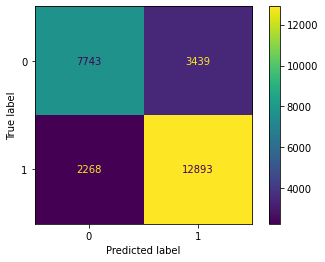

In [55]:
# Classification report and Confusion matrix for GBM model
# GBM model seems to be doing a really good job predicting truly successful campaigns (85% recall rate (or sensitivity/true positive rate))
# However, it is doing much worse at predicting truly unsuccessful projects (only 69% recall rate (or specificity/true negative rate))
print('GBM Model')
print(classification_report(y2_val, model_gbm.predict(X2_val)))
plot_confusion_matrix(model_gbm, X2_val, y2_val, values_format = '.0f');

XGB Model - Validation Data
              precision    recall  f1-score   support

           0       0.78      0.81      0.79     11182
           1       0.85      0.83      0.84     15161

    accuracy                           0.82     26343
   macro avg       0.81      0.82      0.82     26343
weighted avg       0.82      0.82      0.82     26343



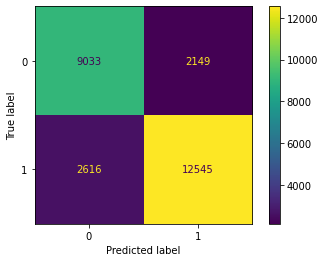

In [61]:
# Classification report and Confusion matrix for XGB model
# XGB model seems to have a great precision when it comes to predicting successful camaigns (it is correct 85% of the times in positive predictions)
# Its precision is worse when predicting unsuccessful campaigns (the model is correct only 78% of the times in negative predictions)
print('XGB Model - Validation Data')
print(classification_report(y2_val, xgb_loaded.predict(X2_val)))
plot_confusion_matrix(xgb_loaded, X2_val, y2_val, values_format = '.0f');

# Conclusion

## Although GBM model has a slightly higher true positive rate (recall) than XBM model (85% GBM versus 83% XGB), the latter seems to be a better overall performer due to:

## - Better true negative rate (recall) -  69% GBM versus 81% XGB
## - Better precision predicting positives - 79% GBM versus 85% XGB
## - Better precision predicting negatives 77% GBM versus 78% XGB
## - The overall model score (weighted average) is better as well - 78% GBM versus 82% XGB

## When using this model (XGB), we need to understand its limitations and keep in mind that its positive predictions (85% correct) are considerably more reliable than negative predictions (78% correct).
## If a user got a negative prediction, they actually still have a 22% chance (100% minus 78%) of succeeding and should evaluate their most important factors (features) to improve their chances.